In [1]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.io.fits as fits
import glob
import os
import pyklip
import pyklip.klip as klip
from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm
import pyklip.parallelized as parallelized
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.instruments.Instrument import GenericData
import pyklip.instruments.NIRC2 as NIRC2
import astropy.units as u
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
import pyklip.fm as fm
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf
import pyklip.fakes as fakes
from astropy.modeling import models, fitting
%matplotlib inline

warnings.filterwarnings("ignore")

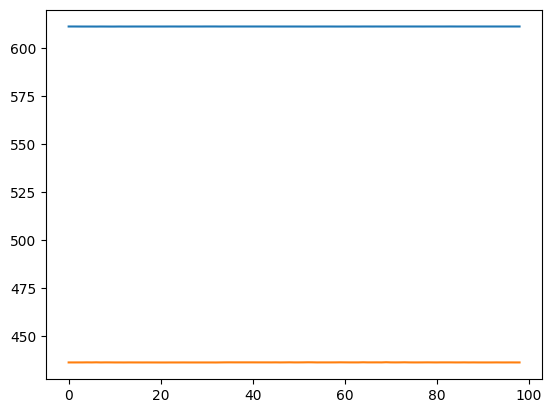

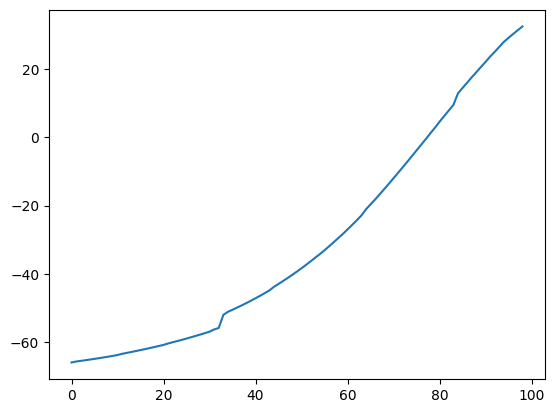

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([615.73853666, 430.36513829]))

In [49]:
#returns median of aligned images to use as PSF
def ADI_psfs(psflist): 
    rawpsfs = np.zeros((len(psflist), 1024, 1024))
    adjustedpsfs = np.zeros((len(psflist), 1024, 1024))
    alignedpsfs = np.zeros((len(psflist), 1024, 1024))
    #shiftentries = (701-60, 487-32)
    for i in range(len(psflist)):
        rawpsfs[i,0:120,0:64] = fits.getdata(psflist[i])
        adjustedpsfs[i, 701-60:701+60,487-32:487+32] = rawpsfs[i,0:120,0:64] // 3000 #normalize to background of zeroes, values used to be order of millions
        #adjustedpsfs[i,:,:] = fourier_shift(rawpsfs[i,:,:], shiftentries)
        if i != 0:
            shifts, error, diffphase = phase_cross_correlation(alignedpsfs[0,:,:], adjustedpsfs[i,:,:], upsample_factor=100)
            alignedpsfs[i,:,:] = fourier_shift(adjustedpsfs[i,:,:], shifts)
        else:
            alignedpsfs[0,:,:] = adjustedpsfs[0,:,:]
            
    medpsfs = np.nanmedian(alignedpsfs, axis=0)

    
    return np.array([medpsfs])

    



#returns fits-processed images, centers, and parallactic angles for every file in the list with given dimensions
def ADI_getImages(flist, xdim, ydim):
    rawcube = np.zeros((len(flist),xdim,ydim))
    ctrs= np.zeros((len(flist),2))
    parangs = np.zeros((len(flist)))
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        #find centers
        if i == 0:
            ctrs[i][0], ctrs[i][1] = 612.6, 434.4         #12_2023_H: 612, 435.7
                                                      #12_2023_CH4s: 598.5, 454
                                                      #12_2023_CH4l: 598.9, 454.2
                                                      #12_2023_J: 612, 436.3
                                                      #12_2023_Ks: 612.6, 434.4
                                                      #02_2023_H: 612.8, 433.9
                                                      #04_2021_CH4s: 600, 453
            
            fits.writeto('rawIMG.fits', rawcube[0,:,:], overwrite=True)
        else:
            shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
                                                    upsample_factor=100,
                                                    normalization=None)
            ctrs[i][0] = ctrs[0][0] - shifts[0]
            ctrs[i][1] = ctrs[0][1] - shifts[1]
            
        parangs[i] = head['PARANG']

    fits.writeto('medIMG.fits', np.nanmedian(rawcube, axis=0), overwrite=True)
    plt.plot(ctrs)
    plt.plot(parangs)
    return rawcube, ctrs, parangs
        
    
#classical ADI
def cADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            #ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))
            
            aligned_cube[0,:,:] = rawcube[0,:,:]
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrPoisson[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va)

    fits.writeto('tempstar.fits',aligned_cube[1,:,:],overwrite=True)
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    return SNR_map, med_derot, ctrs[0]

#ADI

def ADI_NIRC2(flist):
    rawcube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
            
    dataset = GenericData(rawcube, ctrs, IWA=6, parangs=parangs)
    sub_imgs = parallelized.klip_dataset(dataset, outputdir='../klipdata/2023_12_H',
                                        annuli=9,subsections=4,numbasis=[1,20,50,100],maxnumbasis=150,mode="ADI",
                                        movement=1)
    return sub_imgs, ctrs[0]

def makeGaussian(size, amplitude = 1, fwhm = 3, center=None):
    #from andrewgiessel on github

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return amplitude * np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

#Forward-Modeling
def forwardmodel(flist, psflist=None, gaussian=None):
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    dataset = GenericData(datacube, ctrs, IWA=6  , parangs=parangs)
    
    numbasis = np.array([1, 20, 50, 100])
    guesssep = 189.1
    #guesspa = 8.1
    guesspa = 8.6 #for 2023_12_Kshort
    #guesspa = 7.3        #for 2023_02_H
    guessflux = 1.0

    if len(gaussian) > 0:
        print('Gaussian')
        fm_psf_stamp = gaussian[50:71, 50:71]
        fits.writeto('gaussian_model.fits', fm_psf_stamp, overwrite=True)
    elif len(psflist) > 0:
        print('PSF')
        instrument_psfs = ADI_psfs(psflist)
        fm_psf_stamp = instrument_psfs[0, 691:711, 477:497]
        fits.writeto('psf_stamp.fits', fm_psf_stamp, overwrite=True)
    else:
        return

    print(datacube.shape)
    print(fm_psf_stamp.shape)
    fm_psf_stamp = fm_psf_stamp.reshape(1, fm_psf_stamp.shape[0], fm_psf_stamp.shape[1])

    fits.writeto('instrument_psfs.fits', fm_psf_stamp[0], overwrite=True)
    fm_class = fmpsf.FMPlanetPSF(fm_psf_stamp.shape, numbasis, guesssep, guesspa, guessflux, fm_psf_stamp,
                             input_wvs = np.unique(dataset.wvs), flux_conversion = [1]*datacube.shape[0])

    outputdir = "../fmdata/FM_2023_12_Kshort"

    """   ___CHANGE THIS___   """
    
    prefix = "hd47127-12-2023-Kshort" 
    annulus_bounds = [[guesssep-15, guesssep+15]] 
    subsections = 1 
    padding = 0
    movement = 4

    fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement)
    
#   ___CHANGE THIS___   """

datadir = '../rawdata/2023_12_H/'
#datadir = '../rawdata/2023_12_J/'
#datadir = '../rawdata/2023_02_H/'
#datadir = '../rawdata/2023_12_CH4long/'
#datadir = '../rawdata/2023_12_CH4short/'
#datadir = '../rawdata/2023_12_Kshort/'
#datadir = '../rawdata/DEWARPED_2021_04_CH4short/'
flist = sorted(glob.glob(datadir + '*.fits'))
#psflist = sorted(glob.glob(psfdir + '*.fits'))
gaussian = makeGaussian(size=120, amplitude=30, fwhm=6)

#flist_adi, cen = ADI_NIRC2(flist)
#diskForwardmodel(flist, psflist)
#forwardmodel(flist, psflist)
#ADI_NIRC2(flist)
cADI_NIRC2(flist)
#forwardmodel(flist, gaussian=gaussian)
#flist_adi, cen = ADI_NIRC2(flist)

In [ ]:
def processFMObject(output_prefix):
    #next step:
    #exposure time comparison, adjust psfs vs planet images because its measured in absolute counts
    # read in outputs
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")
    
    # get FM frame
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']
    
    # get data_stamp frame
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]
    
    # get initial guesses
    guesssep = fm_hdu[0].header['FM_SEP']
    guesspa = fm_hdu[0].header['FM_PA']

    fit = fitpsf.FMAstrometry(guesssep, guesspa, 13, method="mcmc")
    fit.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)
    fit.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)
    corr_len_guess = 3.
    corr_len_label = r"$l$"
    fit.set_kernel("matern32", [corr_len_guess], [corr_len_label])
    # set bounds
    x_range = 1.5 # pixels
    y_range = 1.5 # pixels
    flux_range = 1. # flux can vary by an order of magnitude
    corr_len_range = 1. # between 0.3 and 30
    fit.set_bounds(x_range, y_range, flux_range, [corr_len_range])
    
    
    # run MCMC fit
    fit.fit_astrometry(nwalkers=100, nburn=200, nsteps=800, numthreads=1)
    fig = pylab.figure(figsize=(10,8))
    
    # grab the chains from the sampler
    chain = fit.sampler.chain
    
    # plot RA offset
    ax1 = fig.add_subplot(411)
    ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)

    ax1.set_xlabel("Steps")
    ax1.set_ylabel(r"$\Delta$ RA")
    
    # plot Dec offset
    ax2 = fig.add_subplot(412)
    ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
    ax2.set_xlabel("Steps")
    ax2.set_ylabel(r"$\Delta$ Dec")
    
    # plot flux scaling
    ax3 = fig.add_subplot(413)
    ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
    ax3.set_xlabel("Steps")
    ax3.set_ylabel(r"$\alpha$")
    
    # plot hyperparameters.. we only have one for this example: the correlation length
    ax4 = fig.add_subplot(414)
    ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
    ax4.set_xlabel("Steps")
    ax4.set_ylabel(r"$l$")

    fig = pylab.figure()
    fig = fit.make_corner_plot(fig=fig)

    fig = pylab.figure()
    fig = fit.best_fit_and_residuals(fig=fig)
    
    fit.propogate_errs(star_center_err=0.05, platescale=.009971, platescale_err=0.000004, pa_offset=0.0, pa_uncertainty=0.13)

    print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fit.raw_RA_offset.bestfit, fit.raw_RA_offset.error,
                                                                                        fit.raw_Dec_offset.bestfit, fit.raw_Dec_offset.error))
    
    # Full error budget included
    print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.RA_offset.bestfit, fit.RA_offset.error))
    print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.Dec_offset.bestfit, fit.Dec_offset.error))
    
    # Propogate errors into separation and PA space
    print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fit.sep.bestfit, fit.sep.error))
    print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fit.PA.bestfit, fit.PA.error))
    
"""   ___CHANGE THIS___   """
output_prefix = '../fmdata/FM_2023_02_H/hd47127-02-2023-H'
processFMObject(output_prefix)

Running burn in


[-0.18 -0.27]
[-0.29 -0.31]
[-0.03 -0.65]
[-0.21 -0.19]
[-1.13  0.  ]
[-0.56 -0.27]
[-0.09 -0.62]
[-0.36  0.09]
[-0.17 -0.35]
[-0.52  0.02]
[-0.78 -0.13]
[-0.38  0.01]
[-0.49 -0.85]
[-0.53 -0.63]
[-0.31 -0.58]
[-0.13 -0.09]
[-0.38 -0.26]
[-0.3  -0.56]
[ 0.07 -0.24]
[ 3.54 -1.83]
[ 3.46 -2.06]
[ 3.53 -2.06]
[ 3.77 -2.48]
[ 3.61 -2.37]
[ 3.73 -1.6 ]
[ 4.04 -1.63]
[ 4.42 -1.66]
[ 4.23 -1.58]
[ 4.44 -1.66]
[ 4.3  -1.67]
[ 4.18 -1.59]
[ 4.44 -1.03]
[ 4.26 -1.66]
[ 4.42 -1.2 ]
[ 4.12 -1.59]
[ 3.86 -1.29]
[ 3.76 -1.73]
[ 4.19 -1.72]
[ 3.72 -0.98]
(60, 60)
Parameter('amplitude', value=224479.9193556412) (30, 30)


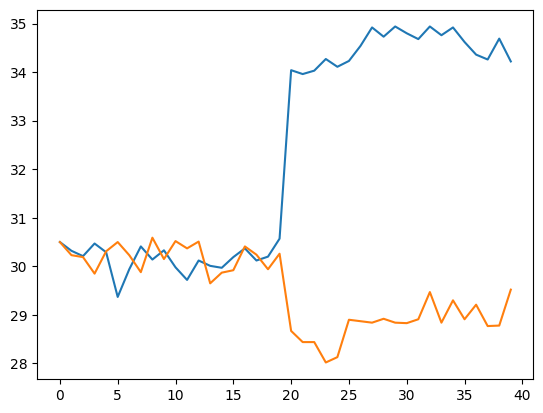

In [27]:
#calculate contrast

from scipy.ndimage import shift
#take in star data
def starData(flist, xdim, ydim):
    rawcube = np.zeros((len(flist), 60, 60))
    alignedcube = np.zeros((len(flist), 60, 60))
    ctrs = []
    for i in range(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])[30:90,2:62]
        if i == 0:
            alignedcube[0,:,:] = rawcube[i,:,:]
            ctrs.append((30.5, 30.5))
        else:
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100, normalization=None)
            print(shifts)
            alignedcube[i,:,:] = shift(rawcube[i,:,:],shift=shifts,mode='grid-constant')
            ctrs.append(ctrs[0]+shifts)
    fits.writeto('temp.fits', rawcube[1,:,:],overwrite=True)
    fits.writeto('tempstar.fits', alignedcube[1,:,:], overwrite=True)
    
    medcube = np.nanmedian(alignedcube, axis=0)
    fits.writeto('medstar.fits', medcube, overwrite=True)
    print(medcube.shape)
    plt.plot(ctrs)
    
    amplitude = calc_starflux(medcube, (29, 32))
    return amplitude, (30, 30)

#fit 2D gaussian (from pyklip.instruments.NIRC2, adjusted slightly)
def calc_starflux(cube, center):
    dims = cube.shape
    y, x = np.meshgrid( np.arange(dims[0]), np.arange(dims[1]) )

    # Initializing Model. Fixing the rotation and the X, Y location of the star.
    g_init = models.Gaussian2D(cube.max(), x_mean=center[0], y_mean=center[1], x_stddev=5, y_stddev=5, \
        fixed={'x_mean':True,'y_mean':True,'theta':True})

    # Initializing Levenburg-Marquart Least-Squares fitting routine.
    fit_g = fitting.LevMarLSQFitter()

    # Fitting the amplitude, x_stddev and y_stddev
    g = fit_g(g_init, y, x, cube)
    return g.amplitude


flist = sorted(glob.glob('../stardata/2023_12_H/*.fits'))
xdim, ydim = 120, 64
amplitude, center = starData(flist, xdim, ydim)

output_prefix = 'medstar'
print(amplitude, center)

[[ 6.2327566  -1.3205512  -7.9364576  ...         nan         nan
          nan]
 [ 1.6275792  -4.362559    1.9942567  ...         nan         nan
          nan]
 [ 5.6627164  -5.6637635  -2.9476862  ...         nan         nan
          nan]
 ...
 [ 0.91484743 -1.4500103  -1.3287534  ...         nan         nan
          nan]
 [-0.20704488  0.3962277   0.25402924 ...         nan         nan
          nan]
 [-1.0732356  -1.4435759   0.2229393  ...         nan         nan
          nan]]


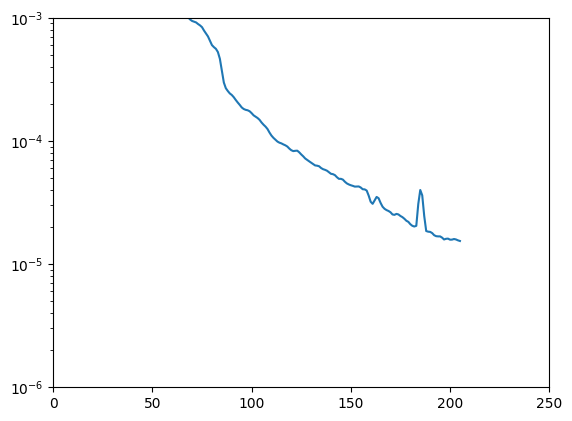

In [36]:
output_prefix = '../klipdata/2023_12_H/'

def contrastCurve(output_prefix, pixel_sep, pa, star_amplitude):
    hdulist = fits.open(output_prefix)
    
    kl20frame = hdulist[0].data[1]
    print(kl20frame)
    dataset_center = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY'] ]
    
    dataset_iwa = 30 # radius of occulter
    dataset_owa = 2.5 / .009971
    dataset_fwhm = 2.5 # fwhm of PSF roughly
    low_pass_size = 1. # pixel, corresponds to the sigma of the Gaussian
    
    # mask beta Pic b
    # first get the location of the planet from Wang+ (2016)
    hd47127b_sep = pixel_sep # pixels
    hd47127b_pa = pa # degrees
    hd47127b_x = pixel_sep * -np.sin(np.radians(pa)) + dataset_center[0]
    hd47127b_y = pixel_sep * np.cos(np.radians(pa)) + dataset_center[1]
    # now mask the data
    ydat, xdat = np.indices(kl20frame.shape)
    distance_from_planet = np.sqrt((xdat - hd47127b_x)**2 + (ydat - hd47127b_y)**2)
    kl20frame[np.where(distance_from_planet <= 2*dataset_fwhm)] = np.nan
    fits.writeto('kl20frame.fits', kl20frame, overwrite=True)

    
    contrast_seps, contrast = klip.meas_contrast(kl20frame, dataset_iwa, dataset_owa, dataset_fwhm, center=dataset_center, low_pass_filter=low_pass_size)
    contrast = contrast / star_amplitude

    plt.xlim(0, 250)
    plt.ylim(1e-6, 1e-3)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.yscale('log')
    plt.plot(np.arange(dataset_iwa, dataset_iwa + len(contrast)), contrast)
    return contrast_seps, contrast

def injectFakePlanets(output_prefix):
    input_planet_fluxes = [1e-4, 1e-5, 1e-6, 1e-7]
    seps = [70, 140, 210, 280]
    fwhm = 4

#calibrated contrast curve with fake planets
#coronographic throughput-corrected contrast curve
contrast_seps, contrast = contrastCurve(output_prefix + "-KLmodes-all.fits", 192.1, 8.2, amplitude + 10000)